<a href="https://colab.research.google.com/github/kavyajeetbora/metro_accessibility/blob/master/notebooks/ETL_Station_Footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the Environment

In [19]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q pydeck
!touch __init__.py

In [20]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import pydeck as pdk
import shapely
import duckdb
import os
import time
import warnings
import requests
from lxml import etree

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Setup duckdb

In [21]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [22]:
%%sql
INSTALL httpfs;
INSTALL spatial;

,Success


In [50]:
duckdb.__version__

'1.1.1'

## Download OSM data

Download all the metro station nodes:

In [23]:
!wget -q https://github.com/kavyajeetbora/metro_accessibility/raw/master/data/delhi/Delhi_NCR_station_nodes.gpkg -O station_nodes.gpkg
station_nodes = gpd.read_file('station_nodes.gpkg')
print("Total Number of stations:",station_nodes.shape[0])
station_nodes.sample(4)

Total Number of stations: 262


,name,railway,network,operator,source,geometry
51,Civil Lines,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.22494 28.67697)
217,Noida Sector 62,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.37352 28.61702)
125,Kaushambi,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.32438 28.64546)
41,Samaypur Badli,station,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.13812 28.74481)


We can quickly visualize all the stations:

<Axes: >

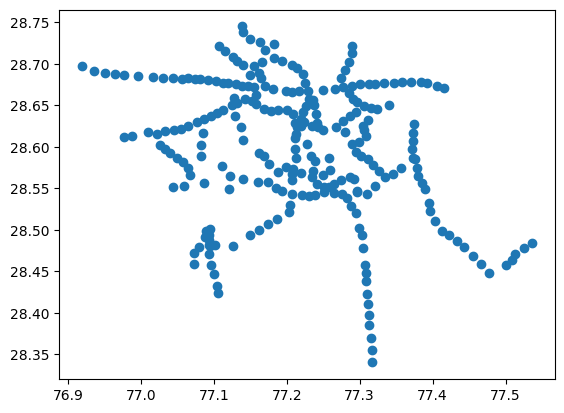

In [25]:
station_nodes.plot()

## Extracting Building Footprints


We will use these those to extract the station building footprints. The data source we will be extracting from:

- **Overture maps**: The Overture Maps Building Footprints dataset includes over 2.3 billion building footprints globally, combining data from sources like OpenStreetMap and Google Open Buildings¹(https://overturemaps.org/overture-buildings-theme-hits-2-3b-buildings-with-addition-of-google-open-buildings-data/). It is updated regularly, with the latest release in September 2024²(https://overturemaps.org/download/). The dataset is maintained by the Overture Maps Foundation, backed by companies like Microsoft, AWS, and Meta³(https://techcrunch.com/2024/07/24/backed-by-microsoft-aws-and-meta-the-overture-maps-foundation-launches-first-open-map-datasets/).
- **Google-Microsoft Open Buildings - combined by VIDA**: This dataset merges Google's V3 Open Buildings and Microsoft's latest Building Footprints. It contains 2,579,035,323 footprints and is divided into 185 partitions. Each footprint is labelled with its respective source, either Google or Microsoft. It can be accessed in cloud-native geospatial formats such as GeoParquet, FlatGeobuf and PMTiles.

## Buffered Stations

Points to consider before intersecting the our nodes with combined building dataset:

- While intersecting the station nodes with the buildings, we will search for buildings within 10m radius from each station node to make sure they are intersecting
- Converting the project to mercator projection for creating a 10m buffer area around the station
- After creating the buffer, we will reproject the geometries to EPSG:4326 as our building dataset is in this crs.





In [26]:
buffered_stations = station_nodes.copy()
buffered_stations = buffered_stations.to_crs('EPSG:3857')
buffered_stations['geometry'] = buffered_stations['geometry'].buffer(10)
buffered_stations = buffered_stations.to_crs("EPSG:4326")
buffered_stations.head(2)

,name,railway,network,operator,source,geometry
0,Noida Sector 51,station,Noida Metro,NR,openstreetmaps,"POLYGON ((77.37538 28.58577, 77.37538 28.58577..."
1,Rainbow Metro Station,station,Noida Metro,NR,openstreetmaps,"POLYGON ((77.37829 28.57437, 77.37829 28.57437..."


In [27]:
# buffered_stations.to_parquet('stations-buffered.parquet')
buffered_stations.geometry.geom_type.unique()

array(['Polygon'], dtype=object)

## Download Station Buildings

Downloading the buildings from overturemaps using duckdb

The overture map's data keeps on updating month on month. Refer to the release notes to download the latest data: [lastest releases](https://docs.overturemaps.org/release/latest/)

Since the overture maps data keeps on getting updated on monthly basis, it is important to stick to the latest available data. You can get the latest release information from their website: [Latest Release Overture Maps Data](https://docs.overturemaps.org/release/latest/) or you can directly scrape the information from their website. Here is a small code to get the latest release info:



In [28]:
try:
    url = r'https://docs.overturemaps.org/release/latest/'
    req = requests.get(url)
    html_text = req.text
    tree = etree.HTML(html_text)

    result = tree.xpath('//h1')
    latest_release = result[0].text
    print("latest Overture map release:" ,latest_release)

except Exception as e:
    print("Error", e)

latest Overture map release: 2024-09-18.0


Extract the bounding box for Delhi:

In [35]:
bbox = pd.read_json(r"https://github.com/kavyajeetbora/metro_accessibility/raw/refs/heads/master/data/bbox.json").to_dict()
W,S,E,N = list(bbox['Delhi_NCR'].values())

Update the `buildings_data_url` to the latest map release and run the code below:

In [63]:
%%time

# Check if the file already exists and remove it
if os.path.exists('overture_buildings.geojson'):
    os.remove('overture_buildings.geojson')

buildings_data_url = rf"s3://overturemaps-us-west-2/release/{latest_release}/theme=buildings/type=*/*"
stations_data_url = "stations-buffered.parquet"

df = duckdb.sql(
    f'''
    COPY(
        SELECT
            sources[1].dataset AS primary_source,
            buildings.geometry
        FROM read_parquet('{buildings_data_url}', filename=true, hive_partitioning=1) AS buildings
        JOIN read_parquet('{stations_data_url}') AS stations
        ON ST_Intersects(buildings.geometry, stations.geometry)
        WHERE buildings.bbox.xmin > {W}
        AND buildings.bbox.xmax < {E}
        AND buildings.bbox.ymin > {S}
        AND buildings.bbox.ymax < {N}
    ) TO 'overture_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
    '''
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 4min 3s, sys: 2.01 s, total: 4min 5s
Wall time: 3min 6s


In [65]:
sbf = gpd.read_file(f'overture_buildings.geojson').drop_duplicates('geometry')  ## Unique Building footprints
print('Stations with enclosing buildings:', sbf.shape[0])
sbf.to_file(f'station_buildings.geojson', driver='GeoJSON')
sbf.sample(5)

Stations with enclosing buildings: 130


,primary_source,geometry
125,Microsoft ML Buildings,"POLYGON ((77.39149 28.67678, 77.39156 28.67675..."
42,OpenStreetMap,"POLYGON ((77.2646 28.55413, 77.26466 28.55416,..."
73,OpenStreetMap,"POLYGON ((77.30607 28.6199, 77.30609 28.62003,..."
8,OpenStreetMap,"POLYGON ((77.3073 28.45706, 77.30759 28.45707,..."
9,Google Open Buildings,"POLYGON ((76.97761 28.61187, 76.97759 28.61194..."


This will give all the building footprints surrounding the station nodes.
Note that buildings are based on overture maps which is not so well updated. There might me some stations without a enclosing building footprint

Let's find out those stations:

In [70]:
station_nodes.head(2)

,name,railway,network,operator,source,geometry
0,Noida Sector 51,station,Noida Metro,NR,openstreetmaps,POINT (77.37529 28.58577)
1,Rainbow Metro Station,station,Noida Metro,NR,openstreetmaps,POINT (77.3782 28.57437)


In [69]:
sbf.head(2)

,primary_source,geometry
0,OpenStreetMap,"POLYGON ((77.07273 28.45913, 77.07281 28.45923..."
1,OpenStreetMap,"POLYGON ((77.31605 28.3553, 77.31607 28.35498,..."


In [131]:
bf = buffered_stations.sjoin(sbf, how='inner', predicate='intersects').copy()
print('Stations with enclosing buildings:', bf.shape[0])

Stations with enclosing buildings: 130


In [133]:
no_bf_index = list(set(station_nodes.index).difference(set(bf.index)))
no_bf = station_nodes.loc[no_bf_index]
print(no_bf.shape)
no_bf.head()

(141, 6)


,name,railway,network,operator,source,geometry
0,Noida Sector 51,station,Noida Metro,NR,openstreetmaps,POINT (77.37529 28.58577)
1,Rainbow Metro Station,station,Noida Metro,NR,openstreetmaps,POINT (77.3782 28.57437)
2,Noida Sector 76,station,Noida Metro,NR,openstreetmaps,POINT (77.37961 28.56536)
3,Noida Sector 101,station,Noida Metro,NR,openstreetmaps,POINT (77.38494 28.55607)
4,Noida Sector 81,station,Noida Metro,NR,openstreetmaps,POINT (77.38993 28.54937)


In [136]:
no_bf.to_parquet("station_with_no_bf.parquet")

## Download building footprints from VIDA


[Google-Microsoft Open Buildings - combined by VIDA](https://beta.source.coop/repositories/vida/google-microsoft-open-buildings/description/):

This dataset merges Google's V3 Open Buildings and Microsoft's latest Building Footprints. With 2,534,595,270 footprints, it is to our knowledge the most complete openly available dataset as of Sep. 2023. It covers 92% of Level 0 administrative boundaries, and is divided into 182 partitions. Each footprint is labelled with its respective source, either Google or Microsoft. It can be accessed in cloud-native geospatial formats such as GeoParquet, FlatGeobuf and PMTiles



Load the building polygons

In [134]:
%%time
stations_data_url = "'stations_buffered.parquet'"
prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
partitions = "by_country"
country_iso = "IND"

duckdb.sql(f'''
describe FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' AS buildings
''')

CPU times: user 4.37 s, sys: 1.91 s, total: 6.29 s
Wall time: 12.6 s


┌────────────────┬────────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name   │                        column_type                         │  null   │   key   │ default │  extra  │
│    varchar     │                          varchar                           │ varchar │ varchar │ varchar │ varchar │
├────────────────┼────────────────────────────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ boundary_id    │ BIGINT                                                     │ YES     │ NULL    │ NULL    │ NULL    │
│ bf_source      │ VARCHAR                                                    │ YES     │ NULL    │ NULL    │ NULL    │
│ confidence     │ DOUBLE                                                     │ YES     │ NULL    │ NULL    │ NULL    │
│ area_in_meters │ DOUBLE                                                     │ YES     │ NULL    │ NULL    │ NULL    │
│ s2_id          │ BIGINT               

In [137]:
if no_bf.shape[0]>0:

    start_time = time.time()

    stations_data_url = "'station_with_no_bf.parquet'"
    prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
    partitions = "by_country"
    country_iso = "IND"

    query = f'''
    COPY(
        SELECT
        ST_Xmin(buildings.geometry) as xmin,
        ST_Xmax(buildings.geometry) as xmax,
        ST_Ymin(buildings.geometry) as ymin,
        ST_Ymax(buildings.geometry) as ymax,
        confidence,
        bf_source,
        buildings.geometry
        FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' as buildings
        JOIN read_parquet({stations_data_url}) as stations
        ON ST_Within(stations.geometry, buildings.geometry)
        WHERE xmin > {W}
        AND xmax < {E}
        AND ymin > {S}
        AND ymax < {N}
    ) TO 'ML_station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
    '''

    duckdb.sql(query)

    end_time = (time.time()-start_time)/60

    print(f"Time taken to process the request: {end_time:2f} mins")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Time taken to process the request: 191.403746 mins


In [138]:
gdf = gpd.read_file('ML_station_buildings.geojson')
print(gdf.shape)

(85, 7)


In [139]:
gdf.sample(5)

,xmin,xmax,ymin,ymax,confidence,bf_source,geometry
39,77.094233,77.095047,28.500494,28.501101,0.9629,google,"POLYGON ((77.09505 28.50069, 77.09438 28.5011,..."
37,77.100335,77.100489,28.446129,28.446426,0.6724,google,"POLYGON ((77.10049 28.44615, 77.10041 28.44643..."
22,77.535917,77.537203,28.484235,28.485077,0.8861,google,"POLYGON ((77.53634 28.48442, 77.53637 28.48438..."
84,76.918577,76.919935,28.697055,28.697866,0.8979,google,"POLYGON ((76.91971 28.69734, 76.91976 28.69741..."
23,77.525138,77.525811,28.478032,28.478527,0.8590,google,"POLYGON ((77.52558 28.47823, 77.52561 28.47818..."


In [ ]:
gpd.read_parquet('stations_stops.parquet')